# Learning and Adjusting Tuning Curves

This is a quick notebook just to sketch out some initial stages of looking at modelling Aaron Batista's data on training macaques to use BCIs, and how that interacts with the represented low-dimensional manifolds in M1.

First, we start with the required dependencies.  They are all Python libraries that can be installed with ```pip``` (e.g. ```pip install nengo```)

In [2]:
%matplotlib inline
import pylab        # plotting
import seaborn      # plotting
import numpy as np  # math functions
import nengo        # neural modelling

Now we build our actual model.  We start by defining M1.  Even though I'll only be extracting 2 dimensions out of this neural activity, I assume that it's probably encoding more than that, so let's go with saying that it's a 3-dimensional manifold.

In [3]:
model = nengo.Network()
with model:
    m1 = nengo.Ensemble(n_neurons=500, dimensions=3)

M1 is gets its inputs from earlier motor areas, so let's add that in.  We'll call it PMC (or maybe SMA), and we'll assume that it's doing a few different things, so let's arbitarily pick that it's a 6-dimensional manifold.

We then connect it to M1.  When we do this, we can specify the relationship that we want between these manifolds and Nengo will find the synaptic connection weights that best approximate that mapping.  This mapping can be a non-linear function (although the more non-linear it is, the less accurately it'll approximate that function).  Here, we just do a linear function that grabs the first 3 dimensions from `pmc` and sends it to `m1`.

This is the connection that will actually end up being adjusted during learning, so we also define a learning rule.  This is the PES rule, which is really just standard delta rule (i.e. a supervised learning rule on just that one set of connections, which ends up being backprop without backpropagation).

In [4]:
with model:
    pmc = nengo.Ensemble(n_neurons=500, dimensions=6)
    
    # function to approximate
    def starting_map(x):
        return x[0], x[1], x[2]
        
    c = nengo.Connection(pmc, m1, function=starting_map,
                         learning_rule_type=nengo.PES(learning_rate=1e-5))


We should have some actual input to our system.  Let's just do a random band-limited white noise signal, with a maximum frequency of 5Hz.  Note that this input is a 6-dimensional input (i.e. it's in the low-D manifold space, not in the 500-D neurons space).  The first 2 dimensions of this we will consider to be our target X,Y location that we want to decode out of the M1 representation.

Note that because of how we set up our connection above, the initial neuron model will be one that does send that information (the values we want to decode) to M1.

In [5]:
with model:
    stim = nengo.Node(nengo.processes.WhiteSignal(period=500, high=5), size_out=6)
    nengo.Connection(stim, pmc)


Now we define our BCI node.  This will take in spiking data from an ensemble of neurons, and apply some linear transform on the spikes, projecting it down into some smaller space.  The begin with, this calls into ```nengo``` to compute the ideal default decoding.  However, if we change this ```self.decoder```, then we change the mapping that the model has to learn.

Note: this is using a few different rather esoteric Nengo tricks, so probably isn't all that readable.  But the final result is something that has as input spikes from N neurons, and as output has a 2-element vector that is formed by linearly combining the spike trains.  By default it's using the *same* linear combination that the full model is using (i.e. as if we were able to find the actual mapping that the macaque is using), but we'll change that to a different mapping that it has to learn.

In [6]:
class BCINode(nengo.Node):
    def __init__(self, ensemble, dimensions, seed=1):
        ensemble.seed = seed
        self.decoder = self.get_decoder(ensemble)[:dimensions]
        super(BCINode, self).__init__(self.decode, size_in=ensemble.n_neurons, size_out=dimensions)

    # defines the behaviour of this Node in the running model
    def decode(self, t, x):
        return np.dot(self.decoder, x)
        
    # use nengo to compute the ideal decoder for this neural population    
    def get_decoder(self, ens):
        assert ens.seed is not None
        net = nengo.Network(add_to_container=False)
        net.ensembles.append(ens)
        with net:
            c = nengo.Connection(ens, ens)
        sim = nengo.Simulator(net, progress_bar=False)
        return sim.data[c].weights
            
        
with model:
    bci = BCINode(m1, dimensions=2)
    nengo.Connection(m1.neurons, bci)



If we left it like this, then the way we're decoding the spikes in the BCI is exactly what the neural model is already doing, so it would give perfect behaviour instantly and there'd be nothing to learn.

Let's give it something to learn by swapping the 2 dimensions being decoded.  That is, we're staying in manifold, but swapping dimension 1 and dimension 2

In [7]:
bci.decoder = np.vstack([bci.decoder[1], bci.decoder[0]])


Now we need to give the system a learning signal.  The solution provided here is cheating a fair bit, in that it already knows which direction to change things to improve the results.  A more complete solution would require learning to characterize the relationship between the observed change in cursor position and the desired change.  This is exactly the sort of learning we've done elsewhere in the adaptive Jacobian kinematics learning models (such as http://rspb.royalsocietypublishing.org/content/283/1843/20162134) but for this demonstration I'm cheating and skipping that part.

In [8]:
with model:
    # population representing the error signal
    error = nengo.Ensemble(n_neurons=500, dimensions=3)
    
    # feedback from the BCI as to where the cursor actually went to
    nengo.Connection(bci, error[:2], transform=1)
    
    # minus the actual desired location
    nengo.Connection(pmc[:2], error[:2], transform=-1)
    
    # use this difference to drive the learning from pmc to m1
    nengo.Connection(error, c.learning_rule, transform=[[0,1,0],[1,0,0],[0,0,1]])
    


Finally, we mark particular data to be recorded during the model run.

In [9]:
with model:
    p_out = nengo.Probe(bci)            # the output from the BCI
    p_stim = nengo.Probe(stim[:2])      # the desired target location
    p_spikes = nengo.Probe(m1.neurons)  # the spike data in m1
    

Now we run the simulation for 500 seconds.

In [10]:
sim = nengo.Simulator(model)
sim.run(500)

Building finished in 0:00:01.                                                   
Simulating finished in 0:05:46.                                                 


Let's see what it's doing at a behavioural level.  First, we plot behaviour in the first second

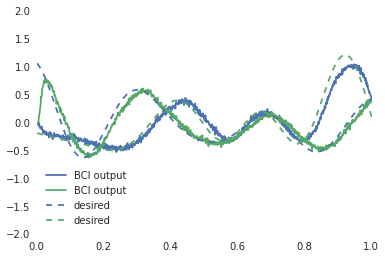

In [13]:
pylab.plot(sim.trange(), sim.data[p_out], label='BCI output')
pylab.gca().set_color_cycle(None)
pylab.plot(sim.trange(), sim.data[p_stim], linestyle='--', label='desired')
pylab.xlim(0,1)
pylab.legend(loc='best')
pylab.show()

As expected, the initial output of the system is exactly backwards (the first dimension and the second dimension are swapped).  

What happens after 100 seconds of learning?

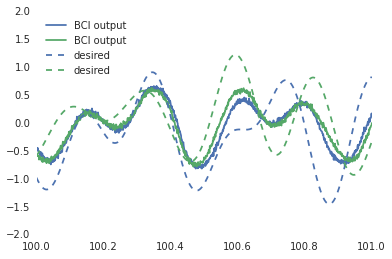

In [15]:
pylab.plot(sim.trange(), sim.data[p_out], label='BCI output')
pylab.gca().set_color_cycle(None)
pylab.plot(sim.trange(), sim.data[p_stim], linestyle='--', label='desired')
pylab.xlim(100, 101)
pylab.legend(loc='best')
pylab.show()

Things have changed, but it's still rather wrong.  

What happens after 200 seconds of learning?

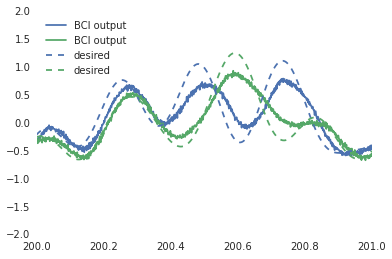

In [16]:
pylab.plot(sim.trange(), sim.data[p_out], label='BCI output')
pylab.gca().set_color_cycle(None)
pylab.plot(sim.trange(), sim.data[p_stim], linestyle='--', label='desired')
pylab.xlim(200, 201)
pylab.legend(loc='best')
pylab.show()

Getting better.

What happens after 500 seconds of learning?

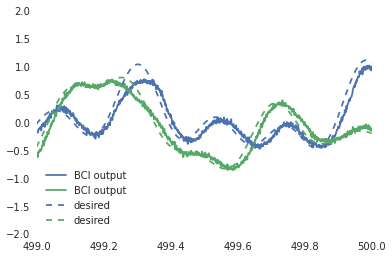

In [17]:
pylab.plot(sim.trange(), sim.data[p_out], label='BCI output')
pylab.gca().set_color_cycle(None)
pylab.plot(sim.trange(), sim.data[p_stim], linestyle='--', label='desired')
pylab.xlim(499, 500)
pylab.legend(loc='best')
pylab.show()

It has successfully learned the new mapping.

## Tuning curves

The whole point of all this was to see what's happening to the tuning curves.

To plot these, the simplest thing to do is just do a density plot of what target x,y locations the neurons spike for at different times in the experiment.

In [19]:
def plot_tuning(index, t_start=0, t_end=10, cmap='Reds'):
    times = sim.trange()
    spikes = sim.data[p_spikes][:,index]
    spikes = np.where(times>t_end, 0, spikes)
    spikes = np.where(times<t_start, 0, spikes)
    
    value = sim.data[p_stim]
    v = value[np.where(spikes>0)]
    seaborn.kdeplot(v[:,0], v[:,1], shade=True, shade_lowest=False, cmap=cmap, alpha=1.0)

Here is the tuning curve for neuron #2, with the initial tuning curve in red (using data from t=0 to t=100) and the final tuning curve in blue (using data from t=400 to t=500).

C:\Python27\lib\site-packages\matplotlib\collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


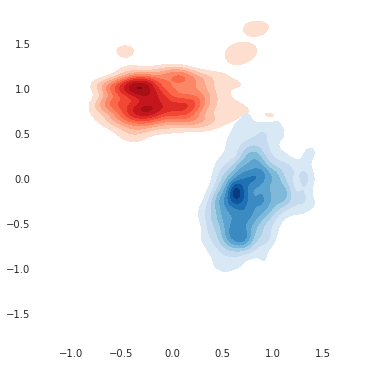

In [20]:
index = 2
pylab.figure(figsize=(6,6))
plot_tuning(index, t_start=0, t_end=100, cmap='Reds')
plot_tuning(index, t_start=400, t_end=500, cmap='Blues')

Here's a neuron that didn't change much

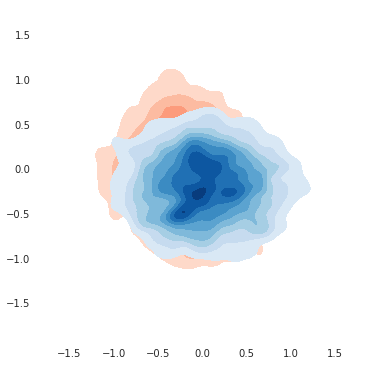

In [21]:
index = 3
pylab.figure(figsize=(6,6))
plot_tuning(index, t_start=0, t_end=100, cmap='Reds')
plot_tuning(index, t_start=400, t_end=500, cmap='Blues')

And some more neurons.

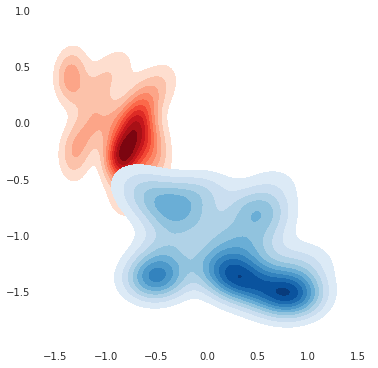

In [23]:
index = 5
pylab.figure(figsize=(6,6))
plot_tuning(index, t_start=0, t_end=100, cmap='Reds')
plot_tuning(index, t_start=400, t_end=500, cmap='Blues')

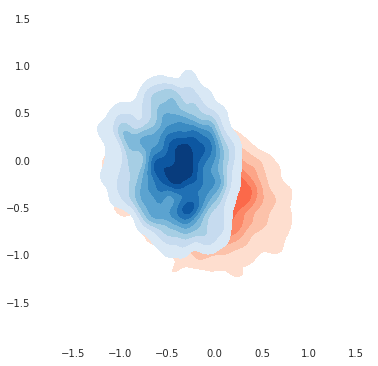

In [24]:
index = 6
pylab.figure(figsize=(6,6))
plot_tuning(index, t_start=0, t_end=100, cmap='Reds')
plot_tuning(index, t_start=400, t_end=500, cmap='Blues')

## Next steps

This was just a quick toy example to see what things might look like.  The big things that would be needed to push this forward (assuming I haven't completely misinterpretted anything) are:

 - Better model of the task (right now it's a just a target dot moving around randomly)
 - Better ways of computing the tuning curve (the current way is biased by the task itself, sampling points in the middle of the space more than the edges)
 - Modelling the error computation process, using the same approach as the adaptive Jacobain motor control model
 - Trying to learn something outside of the manifold
 - Adding unsupervised STDP/BCM learning (the "hPES" rule)